In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from  datetime import datetime
from sklearn.linear_model import LinearRegression
import datetime as dt
import seaborn as sns
sns.set()

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
import math 


# Lectura de Datos

In [7]:
rutaTrain = 'bike_train.xlsx'
rutaTest = 'bike_test.xlsx'
dataTrain  = pd.read_excel(rutaTrain,sheet_name='Sheet1')
dataTest = pd.read_excel(rutaTest,sheet_name='Sheet1')

# Normalización de datos de entrenamiento y de test

In [8]:
dataTrain.head(2)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40


In [9]:
dataTest.head(2)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,12000,2012-05-20,2,1,5,4,0,0,0,1,0.52,0.5000,0.68,0.0896
1,12001,2012-05-20,2,1,5,5,0,0,0,1,0.50,0.4848,0.72,0.1045


Conversion de tipo fecha a ordinal

In [10]:

dataTrain['dteday']=dataTrain['dteday'].map(dt.datetime.toordinal)
dataTest['dteday']=dataTest['dteday'].map(dt.datetime.toordinal)

Ordenar datos por fecha

In [11]:
# datos de entrenamiento
dataTrain= dataTrain.sort_values(by='dteday',ascending=True)
dataTrain.reset_index(inplace = True, drop  = True)
dataTrain = dataTrain.drop(columns=['instant'])

# datos de prueba
dataTest= dataTest.sort_values(by='dteday',ascending=True)
dataTest.reset_index(inplace = True, drop  = True)
dataTest = dataTest.drop(columns=['instant'])


#  Correlacion Lineal

A Continuación, se toma la base que contiene los datos de entrenamiento, y se analizan las variables de mayor correlación linel, teniendo en cuenta que nuestra variable de interés es cnt (conteo de bicicletas)

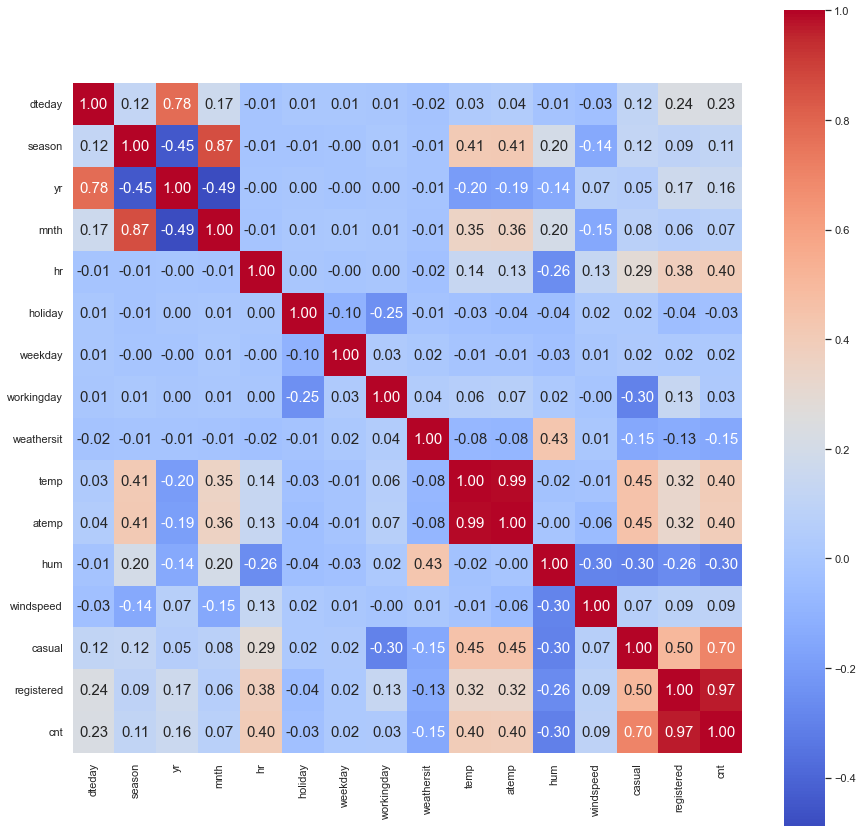

In [12]:
# correlacion lineal en la base de entrenamiento
corr = dataTrain.corr()  #is used for find corelation
plt.figure(figsize=(15,15))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= dataTrain.columns, 
           yticklabels= dataTrain.columns,
           cmap= 'coolwarm')
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)
plt.show()

Visualmente se puede observar que las variables mas correlacionadas linealmente con cnt son las columnas: <br>
registered 0.97<br>
casual 0.70<br>
hr 0.40<br>
temp 0.40<br>
attemp 0.40<br>
hum -0.30<br>
weathersit -0.15<br>

 

### Selector automatico

Sin embargo, se comprobará con la selección automatica de características para verificar el resultado

In [13]:
# se toman las características, excluyendo la variable objetivo cnt
x = dataTrain[dataTrain.columns]
x = x.drop(columns=['cnt'])
x.columns

Index(['dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered'],
      dtype='object')

In [14]:
# se toma la variable objetivo
y = dataTrain[['cnt']]
y.columns

Index(['cnt'], dtype='object')

c:\Users\ALEX\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


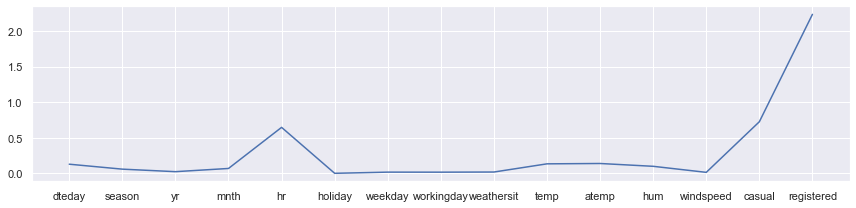

In [15]:
# entrenamiento del algoritmo selector
selector = SelectKBest(mutual_info_regression, k=4)
selector.fit(x,y)

scores = selector.scores_
numCaract = 15
plt.rcParams["figure.figsize"] = [12,3]
plt.plot(scores)
plt.xticks(np.arange(numCaract),list(x.columns));
plt.tight_layout()

In [16]:
puntaje = pd.DataFrame()
caract = pd.DataFrame()
puntaje['puntaje'] =  pd.DataFrame(scores)
caract['columna'] = pd.DataFrame(x.columns)
puntaje = pd.concat([puntaje,caract],axis=1)
puntaje = puntaje.sort_values(by='puntaje',ascending=False)
puntaje.reset_index(inplace=True, drop=True)
puntaje


,puntaje,columna
0,2.234055,registered
1,0.724779,casual
2,0.645604,hr
3,0.137918,atemp
4,0.133108,temp
5,0.128048,dteday
6,0.098312,hum
7,0.068049,mnth
8,0.058470,season
9,0.022974,yr


Con ello se comprueba que las 4 características conocidas como:<br>
registered,<br> casual,<br>hr,<br> atemp,<br> temp<br>
Son las más correlacionadas linealmente.<br>

Sin embargo, existe un problema, las columnas con mayor correlación lineal *registered* con 0.97 y *casual* con 0.70, no se encuentran disponibles en la base de datos en la cual se desea predecir. <br>
Por tanto, es necesario realizar el análisis con las siguientes variables mas correlacionadas que son: <br>
*temp* 0.40<br>
*atemp* 0.40 <br>
*hr*  0.40 <br>
*hum* -0.30 <br>


Relación de las columnas *registered* vs *cnt*

c:\Users\ALEX\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


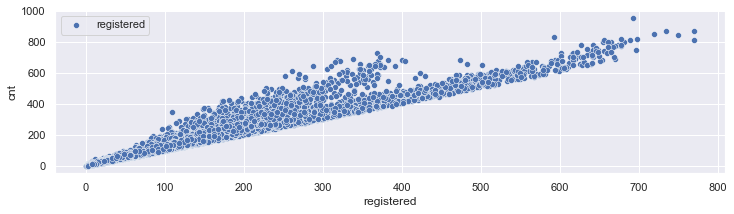

In [17]:
sns.scatterplot(dataTrain['registered'],dataTrain['cnt'],label='registered');


Relación de las columnas *casual vs *cnt*

c:\Users\ALEX\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


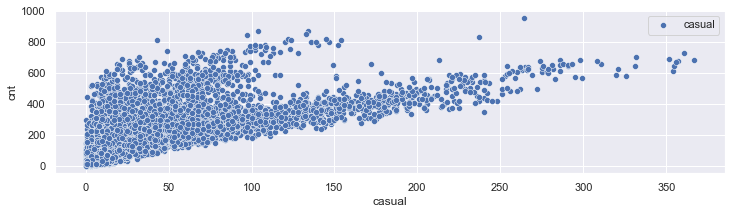

In [18]:
sns.scatterplot(dataTrain['casual'],dataTrain['cnt'],label='casual');

Vemos que estas dos variables (registered,casual) poseen una relación que tiende a ser lineal. <br>
Sin embargo, como se mencionó anteriormente, dichas 2 variables no están disponibles en la base de datos de test, por lo que se debe trabajar con las otras variables, las cuales, lastimosamente no presentan un grado elevado de correlación lineal.

Relación de las columnas *temp* vs *cnt*

c:\Users\ALEX\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='temp', ylabel='cnt'>

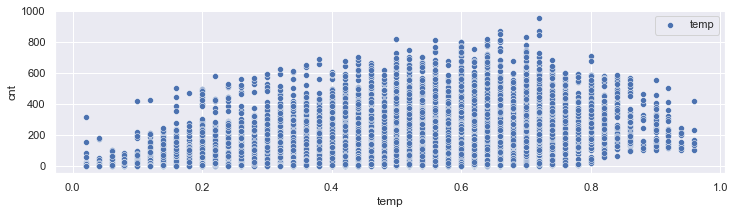

In [19]:
sns.scatterplot(dataTrain['temp'],dataTrain['cnt'],label='temp')

Relación de las columnas *hum* vs *cnt*

c:\Users\ALEX\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='hum', ylabel='cnt'>

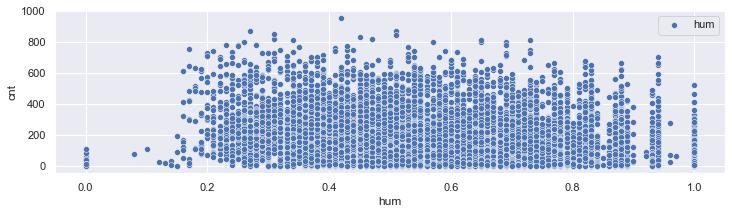

In [20]:
sns.scatterplot(dataTrain['hum'],dataTrain['cnt'],label='hum')

# MODELO DE REGRESION LINEAL

In [21]:
model = LinearRegression(fit_intercept=True)
# preparacion de matriz de caracteriticas
xCaract = dataTrain.temp.values
xCaract = xCaract.reshape(-1,1)
#preparacion de matriz objetivo
yOb = dataTrain.cnt.values
# datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(xCaract, yOb, test_size=0.20, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
# entrenamiento del modelo
model.fit(X_train, y_train)
# evaluación del modelo
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('Error en datos de train:', math.sqrt(mean_squared_error(y_train, y_train_pred)))
print('Error en datos de test:', math.sqrt(mean_squared_error(y_test, y_test_pred)))



(9599, 1)
(2400, 1)
(9599,)
(2400,)
Error en datos de train: 137.96040324364628
Error en datos de test: 143.23310732315056


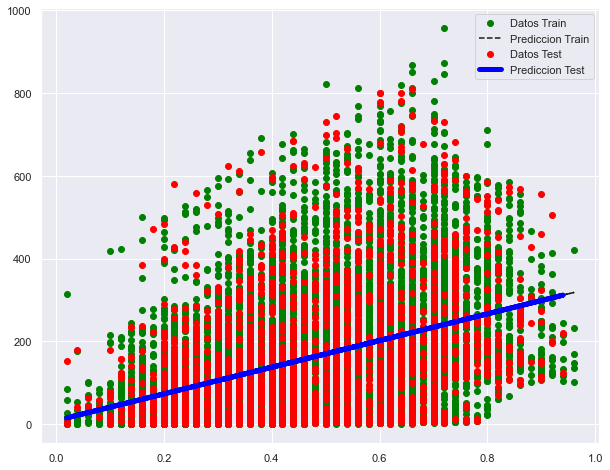

In [22]:
# graficar
plt.figure(figsize = (10,8))


plt.scatter(X_train, y_train,  color='green', label = 'Datos Train')
plt.plot(X_train, y_train_pred, color='k', linestyle = '--', label = 'Prediccion Train')

plt.scatter(X_test, y_test,  color='red', label = 'Datos Test')
plt.plot(X_test, y_test_pred, color='blue', linewidth=5.0, label = 'Prediccion Test')

plt.legend()
plt.show()

Con lo anterior, se puede deducir, que una regresión lineal no es óptima puesto que no se ajusta a distribución de los datos. <br> 
Por tanto es necesario recurrir a otras técnicas, que permitan trabajar con no linealidades como regresión por KNN, con múltiples variables de entrada

La estrategia de predicción a desarrollar consiste en predecir de forma individual las dos columnas más importantes (registered,casual), a partir de sus variables de mayor correlación, para luego, incorporarlas en un nuevo predictor  para estimar el valor del conteo de bicicletas *cnt*, a partir del entrenamiento con las variables previamente estimadas(*registered*,*casual*) y complementarlas  con variables que guarden los mayores valores de correlación.

# KNN REGRESOR MULTIVARIABLE

### Predicción de la variable *casual*

A continuación se predice la variable *casual2* a partir de las características disponibles, para luego compararla con la variable *casual* y ver que tan grande es el error de predicción. <br>
A partir de la matriz de correlación, se puede ver que las variables de mayor relacion son: *temp(0.4)*,  *atemp(0.4)*, *hum(-0.30)*, *hr(0.29)*, *workingday(-0.30)*

In [23]:
#xCaract = dataTrain[['temp','atemp','hum','hr','weathersit','workingday','dteday']].values
# selección decaracterísitcas para entrenamiento
xCaract = dataTrain[['temp','atemp','hum','hr','workingday']].values
# seleccion de caracteríticas de referencia
yOb = dataTrain.casual.values
# datos de entrenamiento y de prueba, usados para la evaluación del algoritmo
X_train, X_test, y_train, y_test = train_test_split(xCaract, yOb, test_size=0.20, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
scaler = StandardScaler()
scaler.fit(X_train);
X_train_scal = scaler.transform(X_train)  
X_test_scal = scaler.transform(X_test)  
# Creación del modelo
n_neighbors = 10
reg_knn = KNeighborsRegressor(n_neighbors = n_neighbors)
reg_knn.fit(X_train_scal,y_train)
# Predicción y evaluación
y_train_pred_knn = reg_knn.predict(X_train_scal)
y_test_pred_knn = reg_knn.predict(X_test_scal)
print('Error en datos de train:', math.sqrt(mean_squared_error(y_train, y_train_pred_knn)))
print('Error en datos de test:', math.sqrt(mean_squared_error(y_test, y_test_pred_knn)))

(9599, 5)
(2400, 5)
(9599,)
(2400,)
Error en datos de train: 17.90308286527328
Error en datos de test: 19.537578641343114


Se puede observar el RMSE tanto en los datos de entrenamiento como de test, son relativamente cercanos, indicando que no probablemente, el algortimo no está sobreentrenado.

### Predicción de la variable *registered*

A continuación se predice la variable *registered2* a partir de las características disponibles, para luego compararla con la variable *registered* y ver que tan grande es el error de predicción. <br>
A partir de la matriz de correlación, se puede ver que las variables de mayor relacion son: *temp(0.32)*,  *atemp(0.32)*, *hum(-0.26)*, *hr(0.38)*, *workingday(-0.13)*  OJO, DTEDAY

In [24]:
#xCaract = dataTrain[['temp','atemp','hum','hr','workingday','dteday']].values
xCaract = dataTrain[['temp','atemp','hum','hr','workingday']].values
#xCaract = xCaract.reshape(-1,2)
xCaract.shape

yOb = dataTrain.registered.values
yOb.shape


X_train, X_test, y_train, y_test = train_test_split(xCaract, yOb, test_size=0.20, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

scaler = StandardScaler()
scaler.fit(X_train);

X_train_scal = scaler.transform(X_train)  
X_test_scal = scaler.transform(X_test)  



# CREACION DEL MODELO
n_neighbors = 10
reg_knn2 = KNeighborsRegressor(n_neighbors = n_neighbors)
reg_knn2.fit(X_train_scal,y_train)

y_train_pred_knn = reg_knn2.predict(X_train_scal)
y_test_pred_knn = reg_knn2.predict(X_test_scal)
print('Error en datos de train:', math.sqrt(mean_squared_error(y_train, y_train_pred_knn)))
print('Error en datos de test:', math.sqrt(mean_squared_error(y_test, y_test_pred_knn)))

(9599, 5)
(2400, 5)
(9599,)
(2400,)
Error en datos de train: 53.92151615224375
Error en datos de test: 64.32755400422641


La diferencia de error entre ambos conjuntos es casi de 10 puntos, por lo que no sería conveniente  tomar sólo esta variable (registered2) para predicir nuestra variable final (cnt). Por tanto, se usará nuevamente knn relacionando múltiples variables

In [25]:
#plt.figure(figsize = (10,8))

# resultados entrenamiento
#plt.scatter(X_train[:,0], y_train,color='green', label = 'Datos Train')
#plt.scatter(X_train[:,0], y_train_pred_knn, color='k',linestyle='--',label = 'Prediccion Train')
# resultados de test
#plt.scatter(X_test[:,0], y_test,color='red', label = 'Datos Test')
#plt.scatter(X_test[:,0], y_test_pred_knn,color='blue', label = 'Prediccion Test')

#plt.legend()
#plt.show()

# AGREGAR COLUMNA CASUAL2 y REGISTERED2

Una vez entrenado el modelo, se procede a agregar las dos columnas (registered2,casual2) a la base de datos de entrenamiento, usando las caracríticas antes descritas para cada una de ellas. 

In [26]:
# agregar la columna casual2
#xCasual2 = dataTrain[['temp','atemp','hum','hr','weathersit','workingday','dteday']].values

# datos de carcterísticas para la variable casual2
xCasual2 = dataTrain[['temp','atemp','hum','hr','workingday']].values
scalerCasual2 = StandardScaler();
scalerCasual2.fit(xCasual2);
x_casual2_pred = scalerCasual2.transform(xCasual2) 
# Predicción y adición a la base de entrenamiento
y_casual2_pred = reg_knn.predict(x_casual2_pred)
dataTrain['casual2'] = y_casual2_pred


#agregar columnma registered2
#xRegistered2 = dataTrain[['temp','atemp','hum','hr','workingday','dteday']].values
#datos de caracteríticas para la variable registered2 
xRegistered2 = dataTrain[['temp','atemp','hum','hr','workingday']].values
scalerRegistered2 = StandardScaler();
scalerRegistered2.fit(xRegistered2);
x_Registered2_pred = scalerRegistered2.transform(xRegistered2) 
y_Registered2_pred = reg_knn2.predict(x_Registered2_pred)
dataTrain['registered2'] = y_Registered2_pred




In [27]:
dataTrain.head(2)

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,casual2,registered2
0,734138,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16,4.8,31.9
1,734138,1,0,1,23,0,6,0,2,0.46,0.4545,0.88,0.2985,15,24,39,19.3,59.3


Como se puede observar, las dos variables ya se encuentran en el conjuntos de datos de entrenamiento

# ENTRENAMIENTO DE LA VARAIBLE OBJETIVO *cnt*

Se toman las dos variables predichas anteriormente, y se complementa con demás variables que guarden correlación.

(9599, 9)
(2400, 9)
(9599,)
(2400,)
Error en datos de train: 49.37276334571226
Error en datos de test: 59.64035249588431


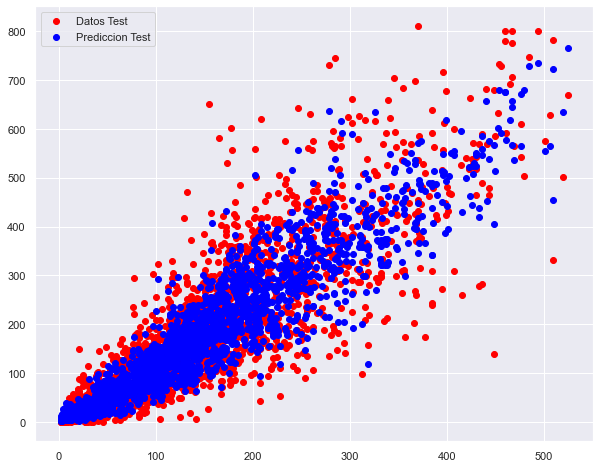

In [28]:
# características de entrenamiento
xCaract = dataTrain[['registered2','casual2','temp','atemp','hum','hr','workingday','dteday','weathersit']].values
#xCaract = xCaract.reshape(-1,2)
#xCaract.shape

#variable objetivo
yOb = dataTrain.cnt.values
#yOb.shape

# Datos de entrenamiento y prueba para comparación
X_train, X_test, y_train, y_test = train_test_split(xCaract, yOb, test_size=0.20, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
scaler = StandardScaler()
scaler.fit(X_train);
X_train_scal = scaler.transform(X_train)  
X_test_scal = scaler.transform(X_test)  


# Creacion del modelo, knn regresor
n_neighbors = 10
reg_knn3 = KNeighborsRegressor(n_neighbors = n_neighbors)
reg_knn3.fit(X_train_scal,y_train)

#predicción  y evaluacion del modelo
y_train_pred_knn = reg_knn3.predict(X_train_scal)
y_test_pred_knn = reg_knn3.predict(X_test_scal)
print('Error en datos de train:', math.sqrt(mean_squared_error(y_train, y_train_pred_knn)))
print('Error en datos de test:', math.sqrt(mean_squared_error(y_test, y_test_pred_knn)))


# graficar resultados
plt.figure(figsize = (10,8))
#plt.scatter(X_train[:,0], y_train,color='green', label = 'Datos Train')
#plt.scatter(X_train[:,0], y_train_pred_knn, color='k',linestyle='--',label = 'Prediccion Train')
# resultados de test
plt.scatter(X_test[:,0], y_test,color='red', label = 'Datos Test')
plt.scatter(X_test[:,0], y_test_pred_knn,color='blue', label = 'Prediccion Test')

plt.legend()
plt.show()

Con ello se puede observar que realiza la predicción de la variable *cnt*, con un error de entrenamiento de 49.37 (RMSE) y de test 59.63 (RMSE). Dado que los errores no están demasiado alejados entre sí, puede indicar que no se está cayendo en sobreentrenamiento.

# PREDICCION

Siguiendo las pasos anteriormente descritos, a la base de datos de test, se le añaden las dos columnas *registered* y *casual* con el modelo entrenado. Y posteriormente se hace la estimación de la columna objetivo *cnt*

In [29]:
dataTest.head(2)

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,734643,2,1,5,4,0,0,0,1,0.52,0.5000,0.68,0.0896
1,734643,2,1,5,23,0,0,0,3,0.60,0.5758,0.78,0.3582


In [30]:
# agregar la columna casual
#xCasual2 = dataTrain[['temp','atemp','hum','hr','weathersit','workingday','dteday']].values

# datos de carcterísticas para la variable casual
xCasual3 = dataTest[['temp','atemp','hum','hr','workingday']].values
scalerCasual3 = StandardScaler();
scalerCasual3.fit(xCasual3);
x_casual3_pred = scalerCasual3.transform(xCasual3) 
# Predicción y adición a la base de entrenamiento
y_casual3_pred = reg_knn.predict(x_casual3_pred)
dataTest['casual'] = y_casual3_pred


#agregar columnma registered
#xRegistered2 = dataTrain[['temp','atemp','hum','hr','workingday','dteday']].values
#datos de caracteríticas para la variable registered2 
xRegistered3 = dataTest[['temp','atemp','hum','hr','workingday']].values
scalerRegistered3 = StandardScaler();
scalerRegistered3.fit(xRegistered3);
x_Registered3_pred = scalerRegistered3.transform(xRegistered3) 
y_Registered3_pred = reg_knn2.predict(x_Registered3_pred)
dataTest['registered'] = y_Registered3_pred



In [31]:
dataTest.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered
0,734643,2,1,5,4,0,0,0,1,0.52,0.5000,0.68,0.0896,3.3,9.7
1,734643,2,1,5,23,0,0,0,3,0.60,0.5758,0.78,0.3582,26.0,83.6
2,734643,2,1,5,22,0,0,0,1,0.62,0.5909,0.73,0.3284,36.0,110.7
3,734643,2,1,5,21,0,0,0,1,0.64,0.6061,0.69,0.3881,43.6,135.8
4,734643,2,1,5,20,0,0,0,1,0.66,0.6212,0.61,0.4179,70.9,184.9


Con ello, se genera la predicción para la variable objetivo *cnt*

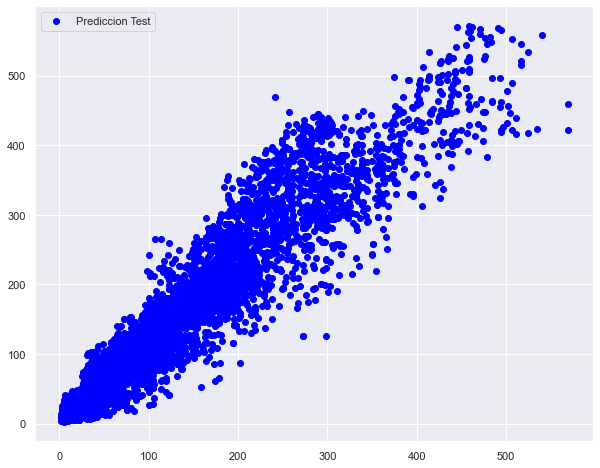

In [32]:
# características de entrenamiento
prueba = dataTest[['registered','casual','temp','atemp','hum','hr','workingday','dteday','weathersit']].values
scaler = StandardScaler()
scaler.fit(prueba);
prueba_scal = scaler.transform(prueba)  
#predicción  y evaluacion del modelo
yPruebaPred = reg_knn3.predict(prueba_scal)

# graficar resultados
plt.figure(figsize = (10,8))
plt.scatter(prueba[:,0], yPruebaPred,color='blue', label = 'Prediccion Test')
plt.legend()
plt.show()

In [33]:
# exporte de resultado en formato csv
pred = pd.DataFrame()
pred['pred'] = pd.DataFrame(yPruebaPred)
pred.to_csv('YEIALEX.csv',index=False,encoding='utf-8')


In [34]:
pred.head(2)

,pred
0,13.2
1,68.4
